# Understanding the Fourier Transform by example
How to implement the Fast Fourier Transform algorithm in Python from scratch. <br />
@author: Simon J. Buehrer <br />
@date: 2021-02-04 <br /><br />
**Links:**
<ul>
<li> https://towardsdatascience.com/fast-fourier-transform-937926e591cb </li>
<li> https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/ </li>
<li> https://towardsdatascience.com/analyzing-seasonality-with-fourier-transforms-using-python-scipy-bb46945a23d3 </li>
</ul> 

In [12]:
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
import datetime as dt 

import yfinance as yf #pip install yfinance /or pip3 /or conda
import numpy as np
import statsmodels.api as sm
from scipy.signal import find_peaks

# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 

import math



## get data

In [13]:
#get current day and download hist. data 
today = dt.datetime.today().strftime('%Y-%m-%d')
hist = (dt.datetime.today()-dt.timedelta(5000)).strftime('%Y-%m-%d')

stockname='ABB'
print(today,hist)
stockdata_df = yf.download(stockname, start=hist, end=today)
print(stockdata_df.tail(5))

2021-02-15 2007-06-09
[*********************100%***********************]  1 of 1 completed
                 Open       High    Low  Close  Adj Close   Volume
Date                                                              
2021-02-08  29.320000  29.389999  28.90  29.08      29.08  2411300
2021-02-09  29.219999  29.420000  29.18  29.34      29.34  1151300
2021-02-10  29.330000  29.379999  28.99  29.18      29.18  1272800
2021-02-11  29.309999  29.410000  29.02  29.26      29.26  1674300
2021-02-12  29.270000  29.549999  29.23  29.52      29.52  1048000


## Calculating the difference (OLS)
und e neui column dezue tue wel datum müesam isch

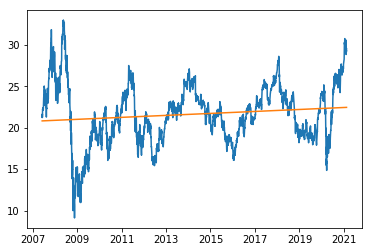

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     58.56
Date:                Mon, 15 Feb 2021   Prob (F-statistic):           2.54e-14
Time:                        20:11:30   Log-Likelihood:                -9310.5
No. Observations:                3446   AIC:                         1.862e+04
Df Residuals:                    3444   BIC:                         1.864e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8167      0.123    169.379      0.0

In [14]:
stockdata_df['row_num'] = np.arange(len(stockdata_df))
X = sm.add_constant(stockdata_df['row_num']) 
model = sm.OLS(stockdata_df['Close'], X).fit()
stockdata_df['OLS'] = model.predict(X) 

plt.plot(stockdata_df.index,stockdata_df['Close']) 
plt.plot(stockdata_df.index,stockdata_df['OLS'])
plt.show() 
print(model.summary())

stockdata_df['Diff']=stockdata_df['Close']-stockdata_df['OLS']

## es paar Diagramm
Afoch welis chan

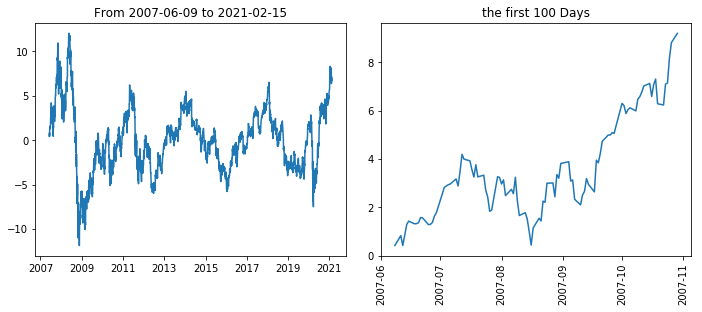

In [15]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index,stockdata_df['Diff']) 
ax1.set_title("From " + hist + " to " +today)

N=100
ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index[:N],stockdata_df['Diff'][:N]) 
ax2.set_title("the first " + str(N) +" Days")

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

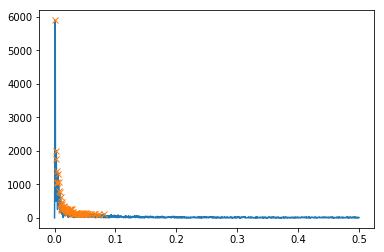

64


In [16]:
fft_output = np.fft.fft(stockdata_df['Diff'])
power = np.abs(fft_output)
freq = np.fft.fftfreq(len(stockdata_df['Diff']))

# mask susch au negativi drinää
mask = freq >= 0
freq = freq[mask]
power = power[mask]

peaks, _ = find_peaks(power[freq >=0], height=100)

plt.plot(freq,power)
plt.plot(freq[peaks], power[peaks],'x')
plt.show() 
print(len(peaks))


In [17]:
output = pd.DataFrame()
output['index'] = peaks
output['freq'] = freq[peaks]
output['amplitude'] = power[peaks]
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output.head()

,index,freq,amplitude,fft
0,4,0.001161,5894.402664,5667.182845-1620.808863j
2,10,0.002902,2001.786373,224.591405+1989.147402j
1,8,0.002322,1744.279744,-1578.615276-741.947190j
3,12,0.003482,1396.635770,1247.023295+628.907288j
6,19,0.005514,1322.539797,-1311.492463+170.584391j


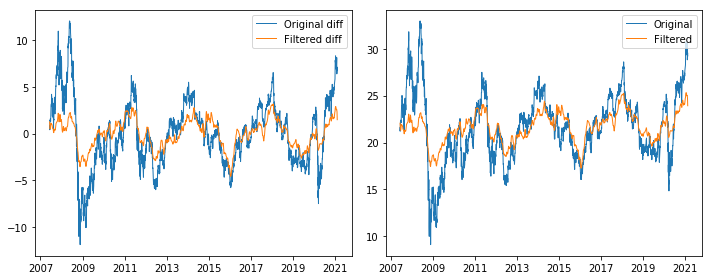

In [18]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_diff = np.fft.ifft(filtered_fft_output)

stockdata_df['Filtered']=stockdata_df['OLS']+filtered_diff

plt.figure(figsize=(10, 4))
ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index, stockdata_df['Diff'], linewidth=1, label='Original diff')
ax1.plot(stockdata_df.index, filtered_diff.real, linewidth=1, label='Filtered diff')
ax1.legend(loc='upper right')

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index, stockdata_df['Close'], linewidth=1, label='Original')
ax2.plot(stockdata_df.index, stockdata_df['Filtered'], linewidth=1, label='Filtered')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Incorporating into our regression

The problem with these sinusoids is that the amplitude is off!

In [19]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq'] = output['freq']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms.head()

,fft,freq,amplitude,phase
label,,,,
FT_1,5667.182845-1620.808863j,0.001161,5894.402664,-0.278563
FT_2,224.591405+1989.147402j,0.002902,2001.786373,1.458364
FT_3,-1578.615276-741.947190j,0.002322,1744.279744,-2.702233
FT_4,1247.023295+628.907288j,0.003482,1396.635770,0.467103
FT_5,-1311.492463+170.584391j,0.005514,1322.539797,3.012250


In [20]:
for key in fourier_terms_dict.keys():
    a = fourier_terms_dict[key]['amplitude']
    w = 2 * math.pi * (fourier_terms_dict[key]['freq'])
    p = fourier_terms_dict[key]['phase']
    stockdata_df[key] = stockdata_df['row_num'].apply(lambda t: a * math.cos(w*t + p))

stockdata_df['FT_All'] = 0
for column in list(fourier_terms.index):
    stockdata_df['FT_All'] = stockdata_df['FT_All'] + stockdata_df[column]


# Sample 
stockdata_df[['Close', 'row_num', 'FT_All']  + list(fourier_terms.index)].head()

,Close,row_num,FT_All,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,...,FT_55,FT_56,FT_57,FT_58,FT_59,FT_60,FT_61,FT_62,FT_63,FT_64
Date,,,,,,,,,,,,,,,,,,,,,
2007-06-08,21.240000,0,4293.055927,5667.182845,224.591405,-1578.615276,1247.023295,-1311.492463,-1072.718531,504.525957,...,20.043828,31.414687,-103.171303,103.311401,-75.648965,-87.346116,-3.811095,4.137441,103.686962,71.262717
2007-06-11,21.650000,1,3545.706510,5678.853075,188.287418,-1567.625223,1232.965466,-1316.613956,-1073.362957,465.150814,...,-17.996304,-14.103013,-71.531235,108.589450,-96.519455,-51.910094,-28.203086,-30.508227,101.263190,33.110636
2007-06-12,21.240000,2,2899.119287,5690.221234,151.920837,-1556.301633,1218.317401,-1320.155470,-1073.093934,424.957743,...,-53.898120,-57.176593,-21.392785,109.027858,-106.972628,-5.537731,-51.041968,-61.715404,89.074875,-11.697046
2007-06-13,21.670000,3,2379.189753,5701.286719,115.503750,-1544.646915,1203.086113,-1322.112754,-1071.911689,384.017420,...,-83.395777,-90.341193,34.277961,104.607086,-105.880277,42.001314,-71.070031,-85.966824,68.297304,-54.153494
2007-06-14,22.110001,4,1999.431686,5712.048940,79.048265,-1532.663550,1187.278893,-1322.483461,-1069.817229,342.401835,...,-102.984370,-107.849228,81.084232,95.524158,-93.360299,80.691584,-87.184354,-100.529183,40.934003,-85.724493


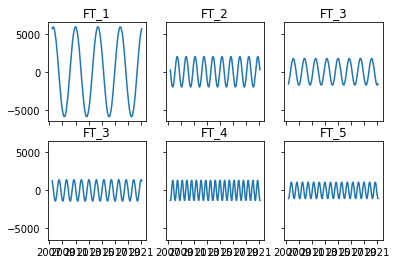

In [21]:

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
for i in range(0,2):
    for j in range(0,3):
        ax[i][j].set_title('FT_'+str(j+1+i*2))
        ax[i][j].plot(stockdata_df.index, stockdata_df['FT_'+str(j+1+i*3)])



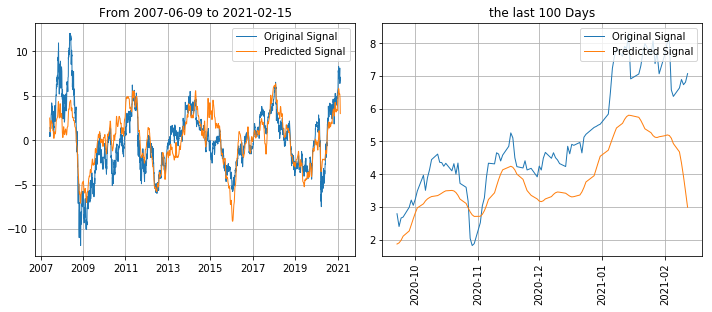

                                 OLS Regression Results                                
Dep. Variable:                   Diff   R-squared (uncentered):                   0.683
Model:                            OLS   Adj. R-squared (uncentered):              0.683
Method:                 Least Squares   F-statistic:                              3717.
Date:                Mon, 15 Feb 2021   Prob (F-statistic):                        0.00
Time:                        20:11:35   Log-Likelihood:                         -7328.9
No. Observations:                3446   AIC:                                  1.466e+04
Df Residuals:                    3444   BIC:                                  1.467e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [22]:
X = pd.DataFrame(stockdata_df[['row_num','FT_All']]) 
y = pd.DataFrame(stockdata_df['Diff'])

model = sm.OLS(y, X).fit()
y_predict = model.predict(X) 


plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index, stockdata_df['Diff'], linewidth=1, label='Original Signal')
ax1.plot(stockdata_df.index, y_predict, linewidth=1, label='Predicted Signal')
ax1.legend(loc='upper right')
ax1.grid()
ax1.set_title("From " + hist + " to " +today)


N=100
ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index[-N:], stockdata_df['Diff'][-N:], linewidth=1, label='Original Signal')
ax2.plot(stockdata_df.index[-N:], y_predict[-N:], linewidth=1, label='Predicted Signal')
ax2.legend(loc='upper right')
ax2.grid()
ax2.set_title("the last " + str(N) +" Days")

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()


print(model.summary())